In [1]:
import cv2
import numpy as np
import time
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

In [2]:
# ROI 범위 설정
(x1,x2), (y1,y2) = (0,640), (0,420)

In [3]:
# 카메라 초기화
cap = cv2.VideoCapture(0)

# FPS 확인
fps = cap.get(cv2.CAP_PROP_FPS)
print(f"카메라 FPS: {fps}")

# 현재 해상도 확인
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
print(f"카메라 해상도: {int(width)}x{int(height)}")

카메라 FPS: 30.0
카메라 해상도: 640x480


In [4]:
# 출력 함수
def frameshow(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.axis('off')  # 축을 숨김
    display(plt.gcf())  # 현재 그림을 디스플레이
    clear_output(wait=True)  # 이전 프레임을 지워서 깔끔하게 만듦

KeyboardInterrupt: 

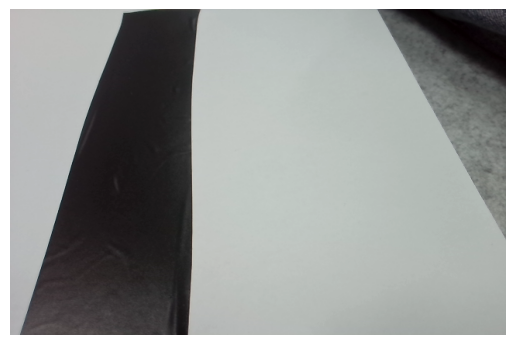

In [8]:
while True:
    ret, frame = cap.read()
    roi_frame = frame[y1:y2, x1:x2]
    frameshow(roi_frame)

In [ ]:
# 직선과 y_center의 실제 교차점 계산 함수
def intersection(x1, y1, x2, y2, y_center):

    # 수직선인 경우
    if x2 - x1 == 0:
        if min(y1, y2) <= y_center <= max(y1, y2):
            return x1
        else:
            return None
    
    # 기울기가 0인 경우
    m = (y2 - y1) / (x2 - x1)
    if m == 0:
        return None
    
    # 교차점 계산
    if min(y1, y2) <= y_center <= max(y1, y2):
        b = y1 - m * x1
        x = (y_center - b) / m
        return x
    
    # 교차하지 않는 경우
    return None

In [ ]:
while True:
    # 카메라에서 프레임 읽기
    ret, frame = cap.read() 
    if not ret: print("프레임을 읽을 수 없음"); break

    # 프레임을 흑백 이미지로 전환
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 블러를 적용하여 노이즈 제거
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # 이진화하여 검은 선 감지
    _, binary = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY_INV)

    edges = cv2.Canny(binary, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 20, None, 10, 2) # 임계값 처음:10 -> 
    y_center = height // 2

    intersection_points = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0] # (x1, y1) : 시작점, (x2, y2) : 끝점
            cv2.line(frame, (x1,y1), (x2, y2), (0,255,0), 3) # 선 그리기 (초록색)

            x_is = intersection(x1, y1, x2, y2, y_center) # 교차점 계산
            if x_is is not None:
                intersection_points.append((x_is, x1, y1, x2, y2))
    
    if len(intersection_points) >= 2:

        # 중앙과 가장 가까운 두 점 선택
        intersection_points.sort(key=lambda p: abs(p[0] - width // 2))
        close_intersection_point_1 = intersection_points[0]
        close_intersection_point_2 = intersection_points[1]

        avg_intersection_point = (close_intersection_point_1[0] + close_intersection_point_2[0]) / 2

        # 중심점 그리기 (빨간색)
        cv2.circle(frame, (int(close_intersection_point_1[0]), y_center), 5, (0, 0, 255), -1)
        cv2.circle(frame, (int(close_intersection_point_2[0]), y_center), 5, (0, 0, 255), -1)

        # direction_text = ""
        # if avg_intersection_point > width // 2:
        #     direction_text = "Turn Left"
        # else:
        #     direction_text = "Turn Right"
        
        # cv2.putText(frame, direction_text, (int(avg_intersection_point) - 30, y_center - 10), 
        #             cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        # dash_length = 20
        # space_length = 10
        # num_dashes = height // (dash_length + space_length)
        # for i in range(num_dashes):
        #     start_y = i * (dash_length + space_length)
        #     end_y = start_y + dash_length
        #     cv2.line(frame, (int(avg_intersection_point), start_y), (int(avg_intersection_point), end_y), (0,255,255), 3)

    cv2.imshow('blur', blurred)
    cv2.imshow('bin', binary)
    cv2.imshow('edges', edges)
    cv2.imshow('Line Detecting', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break

In [ ]:
cap.release()
cv2.destroyAllWindows()